In [ ]:
# The C2QA package is currently not published to PyPI.
# To use the package locally, add the C2QA repository's root folder to the path prior to importing c2qa.
import os
import sys
module_path = os.path.abspath(os.path.join("/Users/kevinsmith/Documents/GitHub/c2qa-qiskit"))
if module_path not in sys.path:
    sys.path.append(module_path)
    
sys.path.insert(0, "..")

from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import c2qa
from qiskit import *

In [4]:
def cDj(delta,j,n):
    # Returns a unitary that displaces a mode conditioned on the jth qubit, by an amount delta*2**j
    qubit_proj = tensor([identity(2)]*j + [basis(2,1)*basis(2,1).dag()] + [identity(2)]*(n-j-1))
    return tensor(qubit_proj,displace(cutoff,delta*(2**j))) + tensor([identity(2)]*j + [basis(2,0)*basis(2,0).dag()] + [identity(2)]*(n-j-1) + [identity(cutoff)])

def D(alpha,n):
    # Returns a unitary that displaces a mode conditioned on the jth qubit, by an amount delta*2**j
    return tensor([identity(2)]*n +[displace(cutoff,alpha)])

def disentangler(n):
    # Exact non-unitary disentangler (the thing we approximate with QSP)
    state_transfer = basis(2,0)*basis(2,0).dag() + basis(2,0)*basis(2,1).dag()
    return tensor([state_transfer]*n + [identity(cutoff)])

def qsp_disentangler(qubit_ind, num_qubits, phases, delta=1.2):
    import scipy
    import pdb
    from qutip.qip.operations.gates import s_gate
    S = s_gate()
    id = identity(2)
    # pdb.set_trace()
    angle_func = lambda x: np.arccos(3/4 + np.cos((x - 2**(qubit_ind-1) + 1/2)*np.pi/(delta*(2**qubit_ind)))/4)
    # angle_func = lambda x: 3/4 + np.cos((x - 2**(qubit_ind-1) + 1/2)*np.pi/(delta*(2**qubit_ind)))/4
    W_angle = Qobj(scipy.linalg.funm(x.full(),angle_func),dims=x.dims)
    
    W = (1j*tensor([id]*qubit_ind + [sigmax()] + [id]*(num_qubits - qubit_ind - 1) + [W_angle])).expm()
    
    def qubit_Zrot(angle):
        return (1j*angle*tensor([id]*qubit_ind + [sigmaz()] + [id]*(num_qubits - qubit_ind - 1) + [identity(cutoff)])).expm()
    
    # Carry out QSP sequence
    U = qubit_Zrot(phases[0])
    for j in range(1,len(phases)):
        U = U*W*qubit_Zrot(phases[j])
        
    # Apply S gate to change from X to iY
    S = tensor([id]*qubit_ind + [s_gate()] + [id]*(num_qubits - qubit_ind - 1) + [identity(cutoff)])
    U = S*U*S.dag()
        
    return U

def qsp_disentangler_qiskit(qubit_ind, num_qubits, phases, delta=1.2):
    import scipy
    import pdb
    from qutip.qip.operations.gates import s_gate
    S = s_gate()
    id = identity(2)
    
    angle_func = lambda x: np.arccos(3/4 + np.cos((x - 2**(qubit_ind-1) + 1/2)*np.pi/(delta*(2**qubit_ind)))/4)
    # angle_func = lambda x: 3/4 + np.cos((x - 2**(qubit_ind-1) + 1/2)*np.pi/(delta*(2**qubit_ind)))/4
    W_angle = Qobj(scipy.linalg.funm(x.full(),angle_func),dims=x.dims)
    
    W = (1j*tensor([sigmax()] + [W_angle])).expm()
    
    def qubit_Zrot(angle):
        return (1j*angle*tensor([sigmaz()] + [identity(cutoff)])).expm()
    
    # Carry out QSP sequence
    U = qubit_Zrot(phases[0])
    # pdb.set_trace()
    for j in range(1,len(phases)):
        U = U*W*qubit_Zrot(phases[j])
        
    # Apply S gate to change from X to iY
    S = tensor([s_gate()] + [identity(cutoff)])
    U = S*U*S.dag()
        
    return U.full()

def qsp_disentangler_x(x, qubit_ind, num_qubits, phases, delta=1.2):
    import scipy
    id = identity(2)
    
    angle_func = lambda x: np.arccos(3/4 + np.cos((x - 2**(qubit_ind-1) + 1/2)*np.pi/(delta*(2**qubit_ind)))/4)
    # angle_func = lambda x: 3/4 + np.cos((x - 2**(qubit_ind-1) + 1/2)*np.pi/(delta*(2**qubit_ind)))/4
    W_angle = angle_func(x)
    
    W = (1j*W_angle*tensor([id]*qubit_ind + [sigmax()] + [id]*(num_qubits - qubit_ind - 1))).expm()
    
    def qubit_Zrot(angle):
        return (1j*angle*tensor([id]*qubit_ind + [sigmaz()] + [id]*(num_qubits - qubit_ind - 1))).expm()
    
    # Carry out QSP sequence
    U = qubit_Zrot(phases[0])
    for j in range(1,len(phases)):
        U = U*W*qubit_Zrot(phases[j])
    return U

def x_to_y(x, qubit_ind, delta=1.2):
    return 3/4 + np.cos((x - 2**(qubit_ind-1) + 1/2)*np.pi/(delta*(2**qubit_ind)))/4

def qsp_disentangler_y(y, qubit_ind, num_qubits, phases, delta=1.2):
    import scipy
    id = identity(2)
    
    W_angle = np.arccos(y)
    
    W = (1j*W_angle*tensor([id]*qubit_ind + [sigmax()] + [id]*(num_qubits - qubit_ind - 1))).expm()
    
    def qubit_Zrot(angle):
        return (1j*angle*tensor([id]*qubit_ind + [sigmaz()] + [id]*(num_qubits - qubit_ind - 1))).expm()
    
    # Carry out QSP sequence
    U = qubit_Zrot(phases[0])
    for j in range(1,len(phases)):
        U = U*W*qubit_Zrot(phases[j])
    return U

In [5]:
from qutip.qip.operations.gates import s_gate
S = s_gate()

In [ ]:
import xlrd
import pandas as pd

phases_df = pd.read_excel('StepFunctionPhases.xlsx',usecols='D, E',skiprows=[0,1,2,3])
phases = phases_df.to_numpy()
phases_df

,"d=60, w=0.24, epsilon = 0.017","d=60, w=0.2, epsilon = 0.02"
0,-2.348647,-1.073167
1,0.944012,3.861488
2,2.257544,-0.542792
3,1.827335,3.533571
4,-0.896501,-0.393472
...,...,...
56,-3.391499,0.156530
57,-2.005372,-0.533215
58,0.505401,-0.460462
59,2.822924,0.611304


## GHZ

In [36]:
# Now carry it out in Bosonic Qiskit
# Qutip state transfer
num_qubits_per_qumode = 8#8
cutoff = 2**num_qubits_per_qumode
a = destroy(cutoff)
x = (a + a.dag())/2

# Shorthand for the initial state accepted by the code below
# Takes a list of lists, where the first list includes amplitudes (that do not need to be normalized),
# and the second are the computational basis states.
qstate = [[1,1],['000','111']]

# Initialize starting state based on qstate
num_qubits = len(qstate[1][0])

# Parameters
w = 0.2 # QSP width -- do not change this as it matches the QSP parameters
delta = 8/(2**(num_qubits)) # spacing between eigenstates
x_width = delta*2**(num_qubits) # roughly the total x-width in phase-space
sigma = np.pi/(2*x_width) # a reasonable choice for the squeezing to make the function "square" in phase-space

# Compute statevector for qubit state
# Now initialize the composite state and normalize
psi0 = 0
for i in range(0,len(qstate[0])):
    psi0 += qstate[0][i]*tensor([basis(2,int(i)) for i in qstate[1][i][::-1]])
psi0 = psi0.unit()
    
# Initialize circuit
qmr = c2qa.QumodeRegister(num_qumodes=1, num_qubits_per_qumode=num_qubits_per_qumode)
qbr = QuantumRegister(num_qubits)
circuit = c2qa.CVCircuit(qmr, qbr)

circuit.initialize([a[0] for a in psi0],qbr)
circuit.draw()

z = -np.log(2*sigma)
circuit.cv_sq(z,qmr[0])

for j in range(0,num_qubits):
    circuit.cv_c_d(0,qmr[0],qbr[j],beta=delta*2**j)

for j in range(0,num_qubits):
    unitary_matrix = qsp_disentangler_qiskit(j, num_qubits, phases[:,1], delta=delta)
    circuit.unitary(unitary_matrix, qmr[0] + [qbr[j]], label='QSP Disentangler')
    
circuit.cv_d((1-2**num_qubits)*delta/2,qmr[0])

stateop, _, _ = c2qa.util.simulate(circuit)


###
# Initialize starting state
num_qubits = len(qstate[1][0])
vacuum = basis(cutoff,0)

psi0 = 0
for i in range(0,len(qstate[0])):
    psi0 += qstate[0][i]*tensor([basis(2,int(i)) for i in qstate[1][i][::-1]] + [vacuum])
psi0 = psi0.unit()

# squeezing parameter
Usqueeze = tensor([identity(2)]*num_qubits + [squeeze(cutoff,z)])

Ucd = 1
for j in range(0,num_qubits):
    Ucd = cDj(delta,j,num_qubits)*Ucd

Dcenter = D((1-2**num_qubits)*delta/2,num_qubits)

# change delta to pi/delta for readout.

# First disentangle with the nonunitary exact disentangler
psi_nu = (Dcenter*disentangler(num_qubits)*Ucd*Usqueeze*psi0).unit()
rho_nu = ptrace(psi_nu,[num_qubits]).unit() # trace out qubits

/Users/kevinsmith/miniconda/envs/quantum/lib/python3.9/site-packages/scipy/sparse/_base.py:1034: SparseEfficiencyWarning: Constructing a DIA matrix with 255 diagonals is inefficient
  return self.tocoo(copy=copy).todia(copy=False)


In [37]:
import matplotlib as mpl
from matplotlib import cm

xvec = np.linspace(-6,6,200)
W = wigner(Qobj(np.array(stateop)), xvec, xvec, g=np.sqrt(2), method = 'clenshaw')
# W = wigner(rho_nu, xvec, xvec, g=np.sqrt(2), method = 'clenshaw')

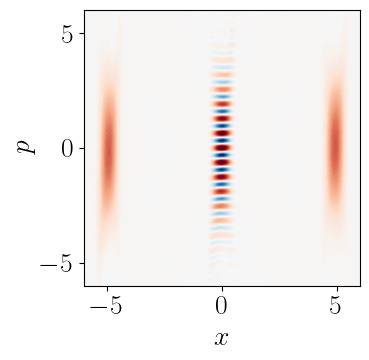

In [38]:
Wmap = wigner_cmap(W)
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plt1 = ax.contourf(xvec, xvec, W, 100, cmap=cm.RdBu_r, norm=mpl.colors.Normalize(-0.25, 0.25))
ax.set_xlim([-6,6])
ax.set_ylim([-6,6])
ax.set_xlabel(r'$x$');
ax.set_ylabel(r'$p$');
# axes[0].legend()
ax.set_aspect('equal', 'box')
# plt.colorbar(plt1, ax = ax, use_gridspec=True)
fig.tight_layout()
plt.savefig('figures/GHZ.pdf',bbox_inches='tight')

In [39]:
rho = c2qa.util.trace_out_qubits(circuit,stateop)
fidelity(Qobj(rho,dims=rho_nu.dims),rho_nu)

0.9720504481371495

## |W>

In [40]:
# Now carry it out in Bosonic Qiskit
# Qutip state transfer

qstate = [[1,1,1],['001','010','100']]


# Initialize starting state based on qstate
num_qubits = len(qstate[1][0])

# Parameters
w = 0.2 # QSP width -- do not change this as it matches the QSP parameters
delta = 8/(2**(num_qubits)) # spacing between eigenstates
x_width = delta*2**(num_qubits) # roughly the total x-width in phase-space
sigma = np.pi/(2*x_width) # a reasonable choice for the squeezing to make the function "square" in phase-space

# Compute statevector for qubit state
# Now initialize the composite state and normalize
psi0 = 0
for i in range(0,len(qstate[0])):
    psi0 += qstate[0][i]*tensor([basis(2,int(i)) for i in qstate[1][i][::-1]])
psi0 = psi0.unit()
    
# Initialize circuit
qmr = c2qa.QumodeRegister(num_qumodes=1, num_qubits_per_qumode=num_qubits_per_qumode)
qbr = QuantumRegister(num_qubits)
circuit = c2qa.CVCircuit(qmr, qbr)

circuit.initialize([a[0] for a in psi0],qbr)
circuit.draw()

z = -np.log(2*sigma)
circuit.cv_sq(z,qmr[0])

for j in range(0,num_qubits):
    circuit.cv_c_d(0,qmr[0],qbr[j],beta=delta*2**j)

for j in range(0,num_qubits):
    unitary_matrix = qsp_disentangler_qiskit(j, num_qubits, phases[:,1], delta=delta)
    circuit.unitary(unitary_matrix, qmr[0] + [qbr[j]], label='QSP Disentangler')
    
circuit.cv_d(-4*delta/2,qmr[0])  

stateop, _, _ = c2qa.util.simulate(circuit)

###
# Initialize starting state
num_qubits = len(qstate[1][0])
vacuum = basis(cutoff,0)

psi0 = 0
for i in range(0,len(qstate[0])):
    psi0 += qstate[0][i]*tensor([basis(2,int(i)) for i in qstate[1][i][::-1]] + [vacuum])
psi0 = psi0.unit()

# squeezing parameter
Usqueeze = tensor([identity(2)]*num_qubits + [squeeze(cutoff,z)])

Ucd = 1
for j in range(0,num_qubits):
    Ucd = cDj(delta,j,num_qubits)*Ucd

Dcenter = D(-4*delta/2,num_qubits)

# change delta to pi/delta for readout.

# First disentangle with the nonunitary exact disentangler
psi_nu = (Dcenter*disentangler(num_qubits)*Ucd*Usqueeze*psi0).unit()
rho_nu = ptrace(psi_nu,[num_qubits]).unit() # trace out qubits

In [41]:
import matplotlib as mpl
from matplotlib import cm

W = wigner(Qobj(np.array(stateop)), xvec, xvec, g=np.sqrt(2), method = 'clenshaw')
Wmap = wigner_cmap(W)

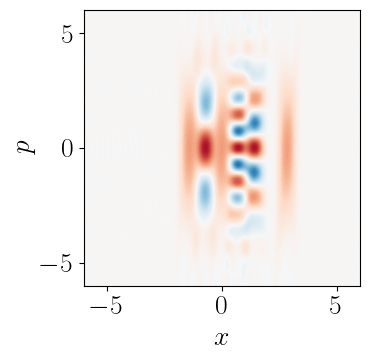

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plt1 = ax.contourf(xvec, xvec, W, 100, cmap=cm.RdBu_r, norm=mpl.colors.Normalize(-0.25, 0.25))
ax.set_xlim([-6,6])
ax.set_ylim([-6,6])
ax.set_xlabel(r'$x$');
ax.set_ylabel(r'$p$');
# axes[0].legend()
ax.set_aspect('equal', 'box')
# plt.colorbar(plt1, ax = ax, use_gridspec=True)
fig.tight_layout()
plt.savefig('figures/W.pdf',bbox_inches='tight')

In [178]:
rho = c2qa.util.trace_out_qubits(circuit,stateop)
fidelity(Qobj(rho,dims=rho_nu.dims),rho_nu)

0.981983474139131

In [190]:
delta

1.0

## |+++>

In [43]:
# Shorthand for the initial state accepted by the code below
# Takes a list of lists, where the first list includes amplitudes (that do not need to be normalized),
# and the second are the computational basis states.
qstate = [[1,1,1,1,1,1,1,1],['000','001','010','011','100','101','110','111']]


# Initialize starting state based on qstate
num_qubits = len(qstate[1][0])

# Parameters
w = 0.2 # QSP width -- do not change this as it matches the QSP parameters
delta = 8/(2**(num_qubits)) # spacing between eigenstates
x_width = delta*2**(num_qubits) # roughly the total x-width in phase-space
sigma = np.pi/(2*x_width) # a reasonable choice for the squeezing to make the function "square" in phase-space

# Compute statevector for qubit state
# Now initialize the composite state and normalize
psi0 = 0
for i in range(0,len(qstate[0])):
    psi0 += qstate[0][i]*tensor([basis(2,int(i)) for i in qstate[1][i][::-1]])
psi0 = psi0.unit()
    
# Initialize circuit
qmr = c2qa.QumodeRegister(num_qumodes=1, num_qubits_per_qumode=num_qubits_per_qumode)
qbr = QuantumRegister(num_qubits)
circuit = c2qa.CVCircuit(qmr, qbr)

circuit.initialize([a[0] for a in psi0],qbr)
circuit.draw()

z = -np.log(2*sigma)
circuit.cv_sq(z,qmr[0])

for j in range(0,num_qubits):
    circuit.cv_c_d(0,qmr[0],qbr[j],beta=delta*2**j)

for j in range(0,num_qubits):
    unitary_matrix = qsp_disentangler_qiskit(j, num_qubits, phases[:,1], delta=delta)
    circuit.unitary(unitary_matrix, qmr[0] + [qbr[j]], label='QSP Disentangler')
    
circuit.cv_d((1-2**num_qubits)*delta/2,qmr[0])

stateop, _, _ = c2qa.util.simulate(circuit)


###
# Initialize starting state
num_qubits = len(qstate[1][0])
vacuum = basis(cutoff,0)

psi0 = 0
for i in range(0,len(qstate[0])):
    psi0 += qstate[0][i]*tensor([basis(2,int(i)) for i in qstate[1][i][::-1]] + [vacuum])
psi0 = psi0.unit()

# squeezing parameter
Usqueeze = tensor([identity(2)]*num_qubits + [squeeze(cutoff,z)])

Ucd = 1
for j in range(0,num_qubits):
    Ucd = cDj(delta,j,num_qubits)*Ucd

Dcenter = D((1-2**num_qubits)*delta/2,num_qubits)

# change delta to pi/delta for readout.

# First disentangle with the nonunitary exact disentangler
psi_nu = (Dcenter*disentangler(num_qubits)*Ucd*Usqueeze*psi0).unit()
rho_nu = ptrace(psi_nu,[num_qubits]).unit() # trace out qubits

In [44]:
import matplotlib as mpl
from matplotlib import cm

W = wigner(Qobj(np.array(stateop)), xvec, xvec, g=np.sqrt(2), method = 'clenshaw')
Wmap = wigner_cmap(W)

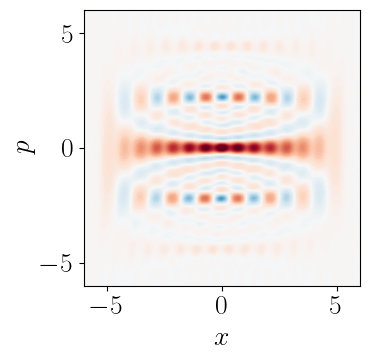

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plt1 = ax.contourf(xvec, xvec, W, 100, cmap=cm.RdBu_r, norm=mpl.colors.Normalize(-0.25, 0.25))
ax.set_xlim([-6,6])
ax.set_ylim([-6,6])
ax.set_xlabel(r'$x$');
ax.set_ylabel(r'$p$');
# axes[0].legend()
ax.set_aspect('equal', 'box')
# plt.colorbar(plt1, ax = ax, use_gridspec=True)
fig.tight_layout()
plt.savefig('figures/ppp.pdf',bbox_inches='tight')

In [183]:
rho = c2qa.util.trace_out_qubits(circuit,stateop)
fidelity(Qobj(rho,dims=rho_nu.dims),rho_nu)

0.980425089097158

## |000>

In [46]:
# Shorthand for the initial state accepted by the code below
# Takes a list of lists, where the first list includes amplitudes (that do not need to be normalized),
# and the second are the computational basis states.
qstate = [[1],['000']]


# Initialize starting state based on qstate
num_qubits = len(qstate[1][0])

# Parameters
w = 0.2 # QSP width -- do not change this as it matches the QSP parameters
delta = 8/(2**(num_qubits)) # spacing between eigenstates
x_width = delta*2**(num_qubits) # roughly the total x-width in phase-space
sigma = np.pi/(2*x_width) # a reasonable choice for the squeezing to make the function "square" in phase-space

# Compute statevector for qubit state
# Now initialize the composite state and normalize
psi0 = 0
for i in range(0,len(qstate[0])):
    psi0 += qstate[0][i]*tensor([basis(2,int(i)) for i in qstate[1][i][::-1]])
psi0 = psi0.unit()
    
# Initialize circuit
qmr = c2qa.QumodeRegister(num_qumodes=1, num_qubits_per_qumode=num_qubits_per_qumode)
qbr = QuantumRegister(num_qubits)
circuit = c2qa.CVCircuit(qmr, qbr)

circuit.initialize([a[0] for a in psi0],qbr)
circuit.draw()

z = -np.log(2*sigma)
circuit.cv_sq(z,qmr[0])

for j in range(0,num_qubits):
    circuit.cv_c_d(0,qmr[0],qbr[j],beta=delta*2**j)

for j in range(0,num_qubits):
    unitary_matrix = qsp_disentangler_qiskit(j, num_qubits, phases[:,1], delta=delta)
    circuit.unitary(unitary_matrix, qmr[0] + [qbr[j]], label='QSP Disentangler')
    
circuit.cv_d(0*delta/2,qmr[0])

stateop, _, _ = c2qa.util.simulate(circuit)


###
# Initialize starting state
num_qubits = len(qstate[1][0])
vacuum = basis(cutoff,0)

psi0 = 0
for i in range(0,len(qstate[0])):
    psi0 += qstate[0][i]*tensor([basis(2,int(i)) for i in qstate[1][i][::-1]] + [vacuum])
psi0 = psi0.unit()

# squeezing parameter
Usqueeze = tensor([identity(2)]*num_qubits + [squeeze(cutoff,z)])

Ucd = 1
for j in range(0,num_qubits):
    Ucd = cDj(delta,j,num_qubits)*Ucd

Dcenter = D(0*delta/2,num_qubits)

# change delta to pi/delta for readout.

# First disentangle with the nonunitary exact disentangler
psi_nu = (Dcenter*disentangler(num_qubits)*Ucd*Usqueeze*psi0).unit()
rho_nu = ptrace(psi_nu,[num_qubits]).unit() # trace out qubits

In [47]:
import matplotlib as mpl
from matplotlib import cm

W = wigner(Qobj(np.array(stateop)), xvec, xvec, g=np.sqrt(2), method = 'clenshaw')
Wmap = wigner_cmap(W)

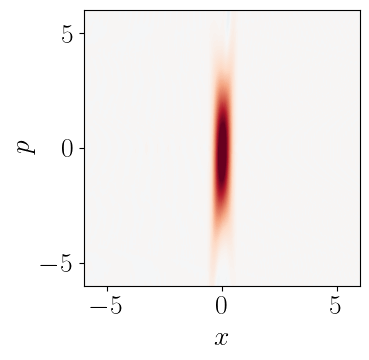

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plt1 = ax.contourf(xvec, xvec, W, 100, cmap=cm.RdBu_r, norm=mpl.colors.Normalize(-0.25, 0.25))
ax.set_xlim([-6,6])
ax.set_ylim([-6,6])
ax.set_xlabel(r'$x$');
ax.set_ylabel(r'$p$');
# axes[0].legend()
ax.set_aspect('equal', 'box')
# plt.colorbar(plt1, ax = ax, use_gridspec=True)
fig.tight_layout()
plt.savefig('figures/000.pdf',bbox_inches='tight')

In [187]:
rho = c2qa.util.trace_out_qubits(circuit,stateop)
fidelity(Qobj(rho,dims=rho_nu.dims),rho_nu)

0.9698224732932695